# 소방서 콜 데이터 분석 보고서 <br> (Fire Station Call Data Analysis Report)


In [1]:
#singleton pattern object builder
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("241206_03_sf_fire_calls_App").getOrCreate()
spark

24/12/10 09:16:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.format("csv")\
    .option("header",'true')\
    .option('inferSchema', 'true')\
    .load("data/sf-fire-calls.csv")

In [77]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import *

# 데이터 자료 조사

In [4]:
df.count()

175296

In [5]:
df.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: integer (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 

In [6]:
df.show(5)

24/12/10 09:17:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+
|CallNumber|UnitID|IncidentNumber|        CallType|  CallDate| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|
+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+------------

In [ ]:
## 각 카테고리 분석

root
 |-- CallNumber: integer (nullable = true) 각 호출에 대한 고유 식별자
 |-- UnitID: string (nullable = true) 호출에 응답한 유닛의 식별자
 |-- IncidentNumber: integer (nullable = true) 사건에 대한 고유 식별자
 |-- CallType: string (nullable = true) 호출 유형 (예: 화재, 응급의료 등)
 |-- CallDate: string (nullable = true) 호출이 발생한 날짜 (호출이 접수된 날짜를 기록)
 |-- WatchDate: string (nullable = true) 호출이 실제로 발송된 날짜
 |-- CallFinalDisposition: string (nullable = true) 호출의 최종 처리 결과 (예: 처리 완료, 취소 등)
 |-- AvailableDtTm: string (nullable = true) 유닛이 다음 호출을 받을 수 있는 시간
 |-- Address: string (nullable = true) 호출과 관련된 사건의 주소
 |-- City: string (nullable = true) 사건이 발생한 도시
 |-- Zipcode: integer (nullable = true) 사건이 발생한 지역의 우편번호
 |-- Battalion: string (nullable = true) 호출에 응답한 소방서의 배타리온(지역 구역)
 |-- StationArea: string (nullable = true) 호출에 응답한 소방서의 지역
 |-- Box: string (nullable = true) 호출에 대한 구체적인 지역 번호 또는 상자 번호
 |-- OriginalPriority: string (nullable = true) 호출에 처음 부여된 우선순위
 |-- Priority: string (nullable = true) 호출에 부여된 최종 우선순위
 |-- FinalPriority: integer (nullable = true) 호출의 최종 우선순위의 숫자 표현
 |-- ALSUnit: boolean (nullable = true) 고급 생명 지원(ALS) 유닛이 호출에 응답했는지 여부
 |-- CallTypeGroup: string (nullable = true) 호출 유형의 범주 
 |-- NumAlarms: integer (nullable = true) 사건에 대한 알람 수
 |-- UnitType: string (nullable = true) 호출에 응답한 유닛의 종류
 |-- UnitSequenceInCallDispatch: integer (nullable = true) 호출에 배정된 유닛의 순서
 |-- FirePreventionDistrict: string (nullable = true) 사건이 발생한 소방 예방 구역
 |-- SupervisorDistrict: string (nullable = true) 사건 발생지의 감독 구역
 |-- Neighborhood: string (nullable = true) 사건이 발생한 지역의 동네
 |-- Location: string (nullable = true) 사건이 발생한 위치에 대한 설명
 |-- RowID: string (nullable = true)데이터셋 내에서 각 행의 고유 식별자
 |-- Delay: double (nullable = true) 유닛이 발송되기까지의 지연 시간

# 데이터 살펴보기 

In [7]:
few_fired_df = (
    df.select("IncidentNumber", "AvailableDtTm", "CallType")\
        .where(col("CallType")!= "Medical Incident")
)
few_fired_df.count()

61502

In [11]:
# 화재 신고로 기록된 CallTyple 종류가 몇 가지 인지 알아보기
df.select("CallType")\
    .where(col("CallType").isNotNull())\
    .agg(countDistinct("CallType").alias("DistinctCallType"))\
    .show()  # 결과를 출력

+----------------+
|DistinctCallType|
+----------------+
|              30|
+----------------+



In [12]:
df.select("CallType")\
    .where(col("CallType").isNotNull())\
    .distinct()\
    .show(10)

+--------------------+
|            CallType|
+--------------------+
|Elevator / Escala...|
|         Marine Fire|
|  Aircraft Emergency|
|Confined Space / ...|
|      Administrative|
|              Alarms|
|Odor (Strange / U...|
|Citizen Assist / ...|
|              HazMat|
|Watercraft in Dis...|
+--------------------+
only showing top 10 rows



In [22]:
# 가장 흔한 형태의 신고 알아보기 - 교재

call_counts = df.select("CallType") \
    .where(col("CallType").isNotNull()) \
    .groupBy("CallType") \
    .count() \
    .orderBy(desc("count")) \

call_counts.show(10)

+--------------------+------+
|            CallType| count|
+--------------------+------+
|    Medical Incident|113794|
|      Structure Fire| 23319|
|              Alarms| 19406|
|   Traffic Collision|  7013|
|Citizen Assist / ...|  2524|
|               Other|  2166|
|        Outside Fire|  2094|
|        Vehicle Fire|   854|
|Gas Leak (Natural...|   764|
|        Water Rescue|   755|
+--------------------+------+
only showing top 10 rows



# 실전 문제 (pg.71)

### Q1. 2018년에 왔던 신고 전화들의 모든 유형은 어떤 것이었는가?

In [26]:
#CallDate의 Year 와 Momth 따로 컬럼 생성
df = df.withColumn("Year", year(to_date("CallDate", "MM/dd/yyyy")))\
                        .withColumn("Month", month(to_date("CallDate", "MM/dd/yyyy")))

# 2018년도만 추출
df_2018_filtered = df.filter(col("Year") == 2018)
df_2018_filtered.select("CallDate", "Year", "Month").show(10)

+----------+----+-----+
|  CallDate|Year|Month|
+----------+----+-----+
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
|01/19/2018|2018|    1|
+----------+----+-----+
only showing top 10 rows



In [131]:
# 2018년에 왔던 신고 전화들의 모든 유형

df_2018_filtered.select("Year", "CallType") \
                .filter(col("CallType").isNotNull()) \
                .distinct() \
                .show()

+----+--------------------+
|Year|            CallType|
+----+--------------------+
|2018|      Structure Fire|
|2018|    Medical Incident|
|2018|              HazMat|
|2018|Gas Leak (Natural...|
|2018|Citizen Assist / ...|
|2018|          Fuel Spill|
|2018|        Water Rescue|
|2018|              Alarms|
|2018|       Assist Police|
|2018|   Traffic Collision|
|2018|Train / Rail Inci...|
|2018|               Other|
|2018|Odor (Strange / U...|
|2018|   Electrical Hazard|
|2018|Elevator / Escala...|
|2018|           Explosion|
|2018|        Outside Fire|
|2018|Smoke Investigati...|
|2018|        Vehicle Fire|
|2018|  Suspicious Package|
+----+--------------------+



### Q2. 2018년에 신고 전화가 가장 많았던 달은 언제인가?

In [37]:
most_calls_month_2018 = df_2018_filtered.groupBy("Year","Month")\
                                        .agg(count("*")\
                                        .alias("Call_Count"))\
                                        .orderBy(desc("Call_Count"))

most_calls_month_2018.show()

+----+-----+----------+
|Year|Month|Call_Count|
+----+-----+----------+
|2018|   10|      1068|
|2018|    5|      1047|
|2018|    3|      1029|
|2018|    8|      1021|
|2018|    1|      1007|
|2018|    7|       974|
|2018|    6|       974|
|2018|    9|       951|
|2018|    4|       947|
|2018|    2|       919|
|2018|   11|       199|
+----+-----+----------+



### Q3. 2018년에 가장 많은 신고가 들어온 샌프란시스코 지역은 어디인가?

In [62]:
# 1. 2018년도 지역 필터링 
year2018_city_filtered = df_2018_filtered.filter(
    (col("City") == "San Francisco") | (col("City") == "SF"))

# 2. 신고 건수 카운트 
neighborhood_counts = year2018_city_filtered.groupBy("Neighborhood") \
                                            .count() \
                                            .orderBy(desc("count"))

neighborhood_counts.show(5)

+--------------------+-----+
|        Neighborhood|count|
+--------------------+-----+
|          Tenderloin| 1393|
|     South of Market| 1052|
|             Mission|  911|
|Financial Distric...|  764|
|Bayview Hunters P...|  513|
+--------------------+-----+
only showing top 5 rows



### Q4. 2018년에 가장 응답 시간이 늦었던 지역은 어디인가?

In [72]:
neighborhood_delay = df_2018_filtered.groupBy("Neighborhood")\
                                        .agg(round(avg("Delay"),2).alias("avg_delay"))\
                                        .orderBy(desc("avg_delay"))
neighborhood_delay.show(5)

+--------------------+---------+
|        Neighborhood|avg_delay|
+--------------------+---------+
|           Chinatown|     6.19|
|            Presidio|     5.83|
|     Treasure Island|     5.45|
|        McLaren Park|     4.74|
|Bayview Hunters P...|     4.62|
+--------------------+---------+
only showing top 5 rows



### Q5. 2018년에 어떤 주에서 신고가 제일 많았는가?

In [54]:
# 1. zipcode 가 몇개인지 확인 - State가 없어서 Zipcode 로 추론 
distinct_zipcodes = df_2018_filtered.select("Zipcode").distinct().count() # 28 Zipcodes

zipcode_counts = df_2018_filtered.groupBy("Zipcode").count().orderBy('count', ascending=False)
zipcode_counts.show(5)

+-------+-----+
|Zipcode|count|
+-------+-----+
|  94103| 1312|
|  94102| 1305|
|  94109|  865|
|  94110|  854|
|  94124|  508|
+-------+-----+
only showing top 5 rows



In [56]:
# Zipcode별 신고 건수 집계
zipcode_count = df_2018_filtered.groupBy("Zipcode").count()

# 신고 건수를 기준으로 순위 매기기
zipcode_window_spec = Window.orderBy(col("count").desc())  # count 기준 내림차순 정렬
ranked_zipcode = zipcode_count.withColumn("zipcode_rank", row_number().over(zipcode_window_spec))

# 결과 표시
ranked_zipcode.select("Zipcode", "count", "zipcode_rank").show(5)

24/12/10 10:30:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+-----+------------+
|Zipcode|count|zipcode_rank|
+-------+-----+------------+
|  94103| 1312|           1|
|  94102| 1305|           2|
|  94109|  865|           3|
|  94110|  854|           4|
|  94124|  508|           5|
+-------+-----+------------+
only showing top 5 rows



### Q6. 지역, 우편번호, 신고 숫자 간에 상관관계가 있는가? 

In [128]:
# 지역, 우편번호, 신고 숫자 컬럼 생성
corr_df = df.groupBy("Neighborhood", "Zipcode")\
            .agg(count("*").alias("Call_count"))\
            .orderBy(desc("Call_count"))

corr_df.show(10)

+--------------------+-------+----------+
|        Neighborhood|Zipcode|Call_count|
+--------------------+-------+----------+
|          Tenderloin|  94102|     17084|
|     South of Market|  94103|     13762|
|             Mission|  94110|     10444|
|Bayview Hunters P...|  94124|      9150|
|             Mission|  94103|      5445|
|          Tenderloin|  94109|      5377|
|Financial Distric...|  94105|      4235|
|      Outer Richmond|  94121|      4121|
|            Nob Hill|  94109|      3983|
| Castro/Upper Market|  94114|      3946|
+--------------------+-------+----------+
only showing top 10 rows



In [129]:
# 상관관계 분석을 위해 "Neighborhood" 수치형으로 나타내기 
indexer = StringIndexer(inputCol="Neighborhood", outputCol="Neighborhood_index")
df_indexed = indexer.fit(corr_df).transform(corr_df)
df_indexed.show(5)

# 3개의 컬럼 하나의 벡터로 결합
assembler = VectorAssembler(inputCols=["Neighborhood_index", "Zipcode", "Call_count"], outputCol="features", handleInvalid="skip")
df_assembled = assembler.transform(df_indexed)

# Corr()
corr = Correlation.corr(df_assembled, "features", method="pearson").head()[0]
print(corr)

+--------------------+-------+----------+------------------+
|        Neighborhood|Zipcode|Call_count|Neighborhood_index|
+--------------------+-------+----------+------------------+
|          Tenderloin|  94102|     17084|              25.0|
|     South of Market|  94103|     13762|              12.0|
|             Mission|  94110|     10444|              17.0|
|Bayview Hunters P...|  94124|      9150|              14.0|
|             Mission|  94103|      5445|              17.0|
+--------------------+-------+----------+------------------+
only showing top 5 rows

DenseMatrix([[ 1.        ,  0.18690961,  0.08312182],
             [ 0.18690961,  1.        , -0.20751415],
             [ 0.08312182, -0.20751415,  1.        ]])


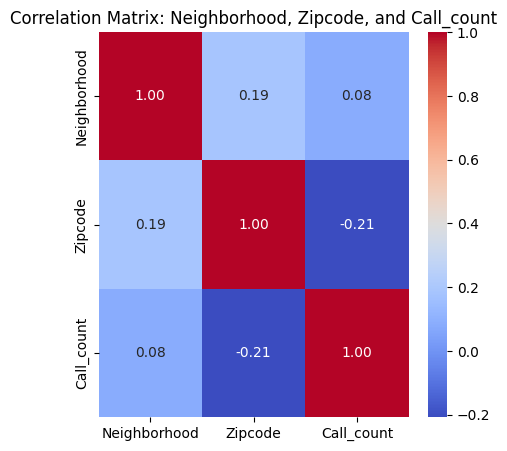

In [134]:
# 시각화

# Pandas DataFrame으로 변환
corr_array = corr.toArray()  # 상관행렬을 numpy 배열로 변환
corr_df = pd.DataFrame(corr_array, columns=["Neighborhood", "Zipcode", "Call_count"], 
                       index=["Neighborhood", "Zipcode", "Call_count"])

# 히트맵 시각화
plt.figure(figsize=(5, 5))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix: Neighborhood, Zipcode, and Call_count")
plt.show()

In [ ]:
# 이 데이터를 어떻게 파케이 파일이나 SQL 테이블로 저장하고 다시 읽을 수 있는가? 

In [135]:
spark.stop()